In [ ]:
## Checking that RYF run does not drift - so that 
## temp + salinity profiles from earlier in the time series can be used

In [1]:
import os

import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
from xgcm import Grid
import glob

import matplotlib.dates as mdates
import datetime
import pandas as pd

In [2]:
%matplotlib inline

In [56]:
from matplotlib import rc
rc('font', **{'size':25})
rc('text', usetex=False)
rc('xtick', labelsize=25) #20 
rc('ytick', labelsize=25) #20
rc('axes', titlesize=25)    # fontsize of the axes title
rc('axes', labelsize=25) #24    # fontsize of the x and y labels

In [12]:
session=cc.database.create_session()

exp_ctrl= '01deg_jra55v13_ryf9091'
lat_lim = slice(-79, -60)
lon_lim = slice(-280,80)

#### SET EXPT HERE
expt = exp_ctrl


from dask.distributed import Client

c=Client(local_directory = '/g/data/v45/qo9901/') 
c 

In [5]:
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

walltime = '03:00:00'
cores = 28
memory = '252GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),processes=cores,
                     job_extra=['-q normalbw','-P v45','-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/ik11+gdata/e14+gdata/hh5+gdata/v45+gdata/cj50',
                                '-l jobfs=400GB'],
                     local_directory='$TMPDIR',
                     header_skip=["select"],
                     #python=os.environ["DASK_PYTHON"]
                    )
cluster

# and if you want even more power, you can use this to make it three nodes
cluster.scale(jobs=3)

# then, run this to make a dask client

c = Client(cluster)
c

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.1:36339,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [115]:
hu = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='hu', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(yu_ocean = slice(-79,-60))
hu

<xarray.DataArray 'hu' (yu_ocean: 440, xu_ocean: 3600)> Size: 6MB
dask.array<getitem, shape=(440, 3600), dtype=float32, chunksize=(440, 900), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
    geolon_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
Attributes:
    long_name:     ocean depth on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    ncfiles:       ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf909...
    contact:       Andy Hogg
    email:         andy.hogg@anu.edu.au
    created:       2020-06-11
    description:   0.1 degree ACCESS-OM2 global model configuration with JRA5...
    notes:         Additional daily outputs saved from 1 Jan 1950 to 31 Dec 1...
    url:           https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra55...

In [6]:
# NEEDload coordinates and grid specifications
geolat_t = cc.querying.getvar(expt, 'geolat_t', session=session, n=1)
geolon_t = cc.querying.getvar(expt, 'geolon_t', session=session, n=1)

dxt = cc.querying.getvar(expt=expt, variable='dxt', session=session, frequency='static', n=1)
dyt = cc.querying.getvar(expt=expt, variable='dyt', session=session, frequency='static', n=1)

dxu = cc.querying.getvar(expt=expt, variable='dxu', session=session, frequency='static', n=1)
dyu = cc.querying.getvar(expt=expt, variable='dyu', session=session, frequency='static', n=1)

In [13]:
#sea_level_lim = sea_level.sel( xt_ocean= lon_lim, yt_ocean=lat_lim, time = flex_period)

# coordinates
lat_t = geolat_t.sel( xt_ocean= lon_lim,yt_ocean=lat_lim)
lon_t = geolon_t.sel(xt_ocean= lon_lim, yt_ocean=lat_lim)

dxt_lim = dxt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)
dyt_lim = dyt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)

dxu_lim = dxu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)
dyu_lim = dyu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)

## Generate Surface geostrophic velocity -  transient

In [14]:
SSH = cc.querying.getvar(expt,'sea_level', session, frequency = '1 monthly').sel(yt_ocean = lat_lim)
SSH # no sea_level

<xarray.DataArray 'sea_level' (time: 3360, yt_ocean: 440, xt_ocean: 3600)> Size: 21GB
dask.array<getitem, shape=(3360, 440, 3600), dtype=float32, chunksize=(1, 440, 900), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * time      (time) object 27kB 1900-01-16 12:00:00 ... 2179-12-16 12:00:00
Attributes: (12/13)
    long_name:      effective sea level (eta_t + patm/(rho0*g)) on T cells
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_height_above_geoid
    ...             ...
    contact:        Andy Hogg
    email:          andy.hogg@anu.edu.au
    created:        2020-06-11
    description:    0.1 degree ACCESS-OM2 global model configuration with JRA...
    notes:          Additional daily outputs saved from 1 Jan 1950 to 31 Dec ...
    url:            https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra5...

In [15]:
patm = 101000 #[Pa, N/m2]
rho0 = 1035 #[kg/m3]
g = 9.81 #[m/s2]
sea_level = SSH #+ patm/(rho0*g) 

#effective sea level (eta_t + patm/(rho0*g)) on T cells (meter)
sea_level = sea_level.chunk({ 'yt_ocean':69, 'xt_ocean':360, 'time':18250})
sea_level_lim = sea_level.sel( xt_ocean= lon_lim, yt_ocean=lat_lim)


In [16]:
sea_level_lim

<xarray.DataArray 'sea_level' (time: 3360, yt_ocean: 440, xt_ocean: 3600)> Size: 21GB
dask.array<rechunk-merge, shape=(3360, 440, 3600), dtype=float32, chunksize=(3360, 69, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * time      (time) object 27kB 1900-01-16 12:00:00 ... 2179-12-16 12:00:00
Attributes: (12/13)
    long_name:      effective sea level (eta_t + patm/(rho0*g)) on T cells
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_height_above_geoid
    ...             ...
    contact:        Andy Hogg
    email:          andy.hogg@anu.edu.au
    created:        2020-06-11
    description:    0.1 degree ACCESS-OM2 global model configuration with JRA...
    notes:          Additional daily outputs saved from 1 Jan 1950 to 31 Dec ...
    url:            https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra5...

In [17]:
cluster_mask_access = xr.open_mfdataset('Antarctic-Eddy-Res-Compare/largest_3cluster_mask_xr_accessom201.nc')
area_u = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='area_u', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(xu_ocean= lon_lim, yu_ocean = lat_lim)

In [18]:
# defining B-grid using xgcm
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
ocean_grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

In [19]:
## need to run seperately or it will crash
import xgcm
coordinates = xr.merge([dxt_lim, dyt_lim, dxu_lim, dyu_lim])

# merge coordinates and variables in one dataset
#vel = xr.merge([coordinates, sea_level_lim.sel(time=flex_period), ocean_grid.sel(time = flex_period)])# time is flex_period before
#vel = xr.merge([coordinates, sea_level_lim.sel(time=flex_period)])#, ocean_grid.sel(time = flex_period)])# time is flex_period before

In [34]:
vel = xr.merge([coordinates, sea_level_lim, ocean_grid.sel( yt_ocean=lat_lim, yu_ocean = lat_lim).isel(time = 0)],compat='override')# time is flex_period before

In [39]:
vel.coords['xt_ocean'].attrs.update(axis='X')
vel.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5, periodic=True)
vel.coords['yt_ocean'].attrs.update(axis='Y')
vel.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5, periodic=False)
metrics = {
    ('X',): ['dxt', 'dxu'], # X distances
    ('Y',): ['dyt', 'dyu'], # Y distances
    ('X', 'Y'): ['area_t', 'area_u'] # Areas
}

In [41]:
grid = xgcm.Grid(vel, periodic=['X'], metrics = metrics,boundary='extend')
grid

<xgcm.Grid>
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
X Axis (periodic, boundary='extend'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center

In [42]:
def geostrophic_velocity(ds, grid, sea_level='sea_level', stream_func='deltaD', gravity='gu', coriolis='f', delta_names=('dx', 'dy')):

    '''
    calculate geostrophic velocity from sea level
    '''
    
    # surface geostrophic velocity
    detadx = grid.interp(grid.diff(ds[sea_level], 'X', boundary='extend'), 'Y', boundary='extend') / ds[delta_names[0]] # , boundary='extend') for 'X'?
    detady = grid.interp(grid.diff(ds[sea_level], 'Y', boundary='extend'), 'X', boundary='extend') / ds[delta_names[1]]

    ds['ug_s']= - (ds[gravity] / ds[coriolis]) * detady
    ds['vg_s'] = (ds[gravity] / ds[coriolis]) * detadx

    ds['ug_s'].name = 'ug_s'
    ds['ug_s'].attrs['standard_name'] = 'surface_geostrophic_eastward_sea_water_velocity'
    ds['ug_s'].attrs['long_name'] = r'$u_g,s$'
    ds['ug_s'].attrs['units'] = r'$\mathrm{ms}^{-1}$'
    
    ds['vg_s'].name = 'vg_s'
    ds['vg_s'].attrs['standard_name'] = 'surface_geostrophic_northward_sea_water_velocity'
    ds['vg_s'].attrs['long_name'] = r'$v_g,s$'
    ds['vg_s'].attrs['units'] = r'$\mathrm{ms}^{-1}$'
    
    return ds

In [43]:
from gsw import f, grav, p_from_z

In [44]:
g = xr.apply_ufunc(grav, lat_t, patm, dask='parallelized') ## CHEKC IF Patm is riht for surface
## not allowed to leave p empty
g.name = 'g'
g.attrs = {'standard_name': 'gravitational_acceleration', 'units':r'$\textrm{ms}^{-2}$', 'long_name': 'gravitational acceleration'}

# Coriolis parameter
fcor, _ = xr.broadcast(f(coordinates.yu_ocean), coordinates.xu_ocean)
fcor.name = 'f'
fcor.attrs = {'standard_name': 'coriolis_parameter', 'units': r'$\textrm{s}^{-1}$', 'long_name': 'Coriolis parameter'}

gu = grid.interp(grid.interp(g, 'X', boundary='extend'), 'Y', boundary='extend') ## interpolated gravity to u grid
gu.name = 'gu'

In [46]:
sl_grd = xr.merge([coordinates, gu, fcor, sea_level_lim])
sl_grd

<xarray.Dataset> Size: 21GB
Dimensions:    (xt_ocean: 3600, yt_ocean: 440, xu_ocean: 3600, yu_ocean: 440,
                time: 3360)
Coordinates:
  * xt_ocean   (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean   (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.1 -60.05
    geolon_t   (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
  * xu_ocean   (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean   (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
    geolon_c   (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    geolat_c   (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
  * time       (time) object 27kB 1900-01-16 12:00:00 ... 2179-12-16 12:00:00
Data variables:
    dxt        (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    dyt        (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    dxu        (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    dyu        (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    gu         (yu_ocean, xu_ocean) float64 13MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    f          (yu_ocean, xu_ocean) float64 13MB -0.0001432 ... -0.0001263
    sea_level  (time, yt_ocean, xt_ocean) float32 21GB dask.array<chunksize=(3360, 69, 360), meta=np.ndarray>
Attributes:
    long_name:     ocean dxt on t-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    ncfiles:       ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf909...
    contact:       Andy Hogg
    email:         andy.hogg@anu.edu.au
    created:       2020-06-11
    description:   0.1 degree ACCESS-OM2 global model configuration with JRA5...
    notes:         Additional daily outputs saved from 1 Jan 1950 to 31 Dec 1...
    url:           https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra55...

Now, we just have to provide the function geostrophic_velocity with the variables in the Dataset, the Grid made with xgcm, we set stream_func to None, because we only calculate the geostrophic velocities at the surface and we provide the names of dx and dy in the Dataset.

In [47]:
sl_grd = sl_grd.chunk({'yt_ocean':93,'xt_ocean':600})#makexy domain one chunk only

In [48]:
geos_vel = geostrophic_velocity(sl_grd, grid, stream_func=None, delta_names=('dxu', 'dyu'))

# calculating the geostrophic flow speed
Vg = (geos_vel.ug_s**2 + geos_vel.vg_s**2)**(1/2)

In [49]:
Vg = Vg.chunk({ 'yu_ocean':69, 'xu_ocean':60, 'time':5000})
u = geos_vel.ug_s.sel(yu_ocean=lat_lim, xu_ocean = lon_lim)#.chunk({ 'yu_ocean':69, 'xu_ocean':60, 'time':5000})#.mean('time')
v = geos_vel.vg_s.sel(yu_ocean=lat_lim, xu_ocean = lon_lim)#.chunk({ 'yu_ocean':69, 'xu_ocean':60, 'time':5000})#.mean('time')

In [53]:
u_int_circ = grid.integrate(u.where(cluster_mask_access == True), axis = {'X','Y'})
u_int_circ.load()

<xarray.Dataset> Size: 54kB
Dimensions:                        (time: 3360)
Coordinates:
  * time                           (time) object 27kB 1900-01-16 12:00:00 ......
Data variables:
    __xarray_dataarray_variable__  (time) float64 27kB -3.01e+10 ... -5.579e+10

In [54]:
v_int_circ = grid.integrate(v.where(cluster_mask_access == True), axis = {'X','Y'})
v_int_circ.load()

<xarray.Dataset> Size: 54kB
Dimensions:                        (time: 3360)
Coordinates:
  * time                           (time) object 27kB 1900-01-16 12:00:00 ......
Data variables:
    __xarray_dataarray_variable__  (time) float64 27kB 6.963e+09 ... 6.807e+09

In [63]:
circ_area = (area_u*cluster_mask_access).sum().__xarray_dataarray_variable__.values 
circ_area

array(3.917276e+12, dtype=float32)

In [70]:
u_int_circ = u_int_circ.rename_vars({'__xarray_dataarray_variable__':'u'})/circ_area
u_int_circ['u'] = u_int_circ.u.assign_attrs(units='m/s')

In [77]:
u_int_circ.time

<xarray.DataArray 'time' (time: 3360)> Size: 27kB
array([cftime.DatetimeNoLeap(1900, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2179, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2179, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2179, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 27kB 1900-01-16 12:00:00 ... 2179-12-16 12:00:00
Attributes:
    long_name:       time
    cartesian_axis:  T
    calendar_type:   NOLEAP
    bounds:          time_bounds

In [80]:
import cftime

In [91]:
perturb_u = (u_int_circ.u).sel(time = slice('2110','2160')).mean()
ctrl_u = (u_int_circ.u).sel(time = slice('1950','1959')).mean()
(ctrl_u- perturb_u)/ctrl_u*100

<xarray.DataArray 'u' ()> Size: 8B
array(2.35148549)

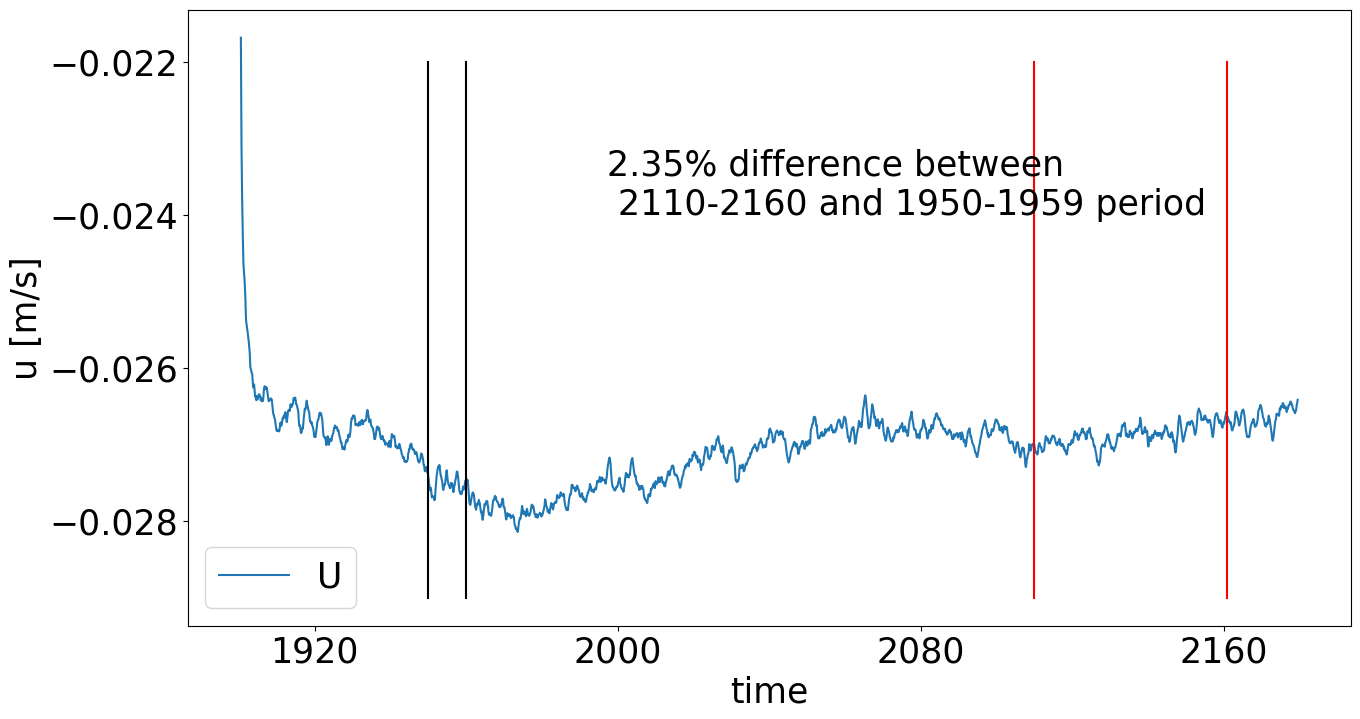

In [114]:
plt.figure( figsize = (15,8))
(u_int_circ.u.rolling(time = 12, center = True).mean()).plot(label = 'U')
#(v_int_circ.__xarray_dataarray_variable__.rolling(time = 12, center = True).mean()/circ_area).plot(label = 'V')
plt.plot([cftime.DatetimeNoLeap(1950, 1, 16, 12, 0, 0, 0, has_year_zero=True),cftime.DatetimeNoLeap(1950, 1, 16, 12, 0, 0, 0, has_year_zero=True)],[-0.029,-0.022], 'k')
plt.plot([cftime.DatetimeNoLeap(1959, 12, 16, 12, 0, 0, 0, has_year_zero=True),cftime.DatetimeNoLeap(1959, 12, 16, 12, 0, 0, 0, has_year_zero=True)],[-0.029,-0.022], 'k')
#plt.plot([cftime.DatetimeNoLeap(1970, 12, 16, 12, 0, 0, 0, has_year_zero=True),cftime.DatetimeNoLeap(1970, 12, 16, 12, 0, 0, 0, has_year_zero=True)],[-0.029,-0.022], 'k')

plt.plot([cftime.DatetimeNoLeap(2110, 1, 16, 12, 0, 0, 0, has_year_zero=True),cftime.DatetimeNoLeap(2110, 1, 16, 12, 0, 0, 0, has_year_zero=True)],[-0.029,-0.022], 'r')
plt.plot([cftime.DatetimeNoLeap(2160, 12, 16, 12, 0, 0, 0, has_year_zero=True),cftime.DatetimeNoLeap(2160, 12, 16, 12, 0, 0, 0, has_year_zero=True)],[-0.029,-0.022], 'r')
plt.text(-1000, -0.024,'2.35% difference between\n 2110-2160 and 1950-1959 period')
plt.legend()

In [ ]:
## slope vs shelf and along slope

In [116]:
mask_shelf = xr.where(hu<1000 , True, False)
mask_slope = xr.where(hu>1000, True, False)

In [117]:
def calc_u_along_integral_mask_tt(tt, chunk_size, mask_region):
    u_t = u.isel(time = slice(tt*chunk_size, chunk_size*(tt+1))).where(cluster_mask_access == True).where(mask_region == True).load()
    v_t = v.isel(time = slice(tt*chunk_size, chunk_size*(tt+1))).where(cluster_mask_access == True).where(mask_region == True).load()
    
    u_comp = (u_t*dhu_dy/slope).__xarray_dataarray_variable__#.compute()
    v_comp = (v_t*dhu_dx/slope).__xarray_dataarray_variable__#.compute()
    u_along = u_comp.chunk({ 'yu_ocean':100, 'xu_ocean':50}) - v_comp.chunk({ 'yu_ocean':100, 'xu_ocean':50})
    u_along_tt = grid.integrate(u_along, axis = {'X', 'Y'}).load()#.values
    print(tt)
    return u_along_tt

In [119]:
dhu_dx = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/dhu_dx_circfield').__xarray_dataarray_variable__#.chunk({ 'yu_ocean':69, 'xu_ocean':60})
dhu_dy = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/dhu_dy_circfield').__xarray_dataarray_variable__#.chunk({ 'yu_ocean':69, 'xu_ocean':60})
slope = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/slope_circfield').__xarray_dataarray_variable__


OSError: no files to open